# Project: Multiclass Classification Using KNN for Iris Dataset

## 1: Import libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## 2: Import & Visualize data

### Import

In [2]:
ds = pd.read_csv("breast-cancer-wisconsin.data", header = None) #
ds.columns = ['sample_code_number','clump_thickness','uniformity_of_cell_size','uniformity_of_cell_shape','marginal_adhesion','single_epithelial_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses','Class']

### Visualize

#### See raw data

In [3]:
ds.head
print(f"shape ds1: {ds.shape}")

shape ds1: (699, 11)


#### Observe relationships 

1. Distribution of classes between different parrameters

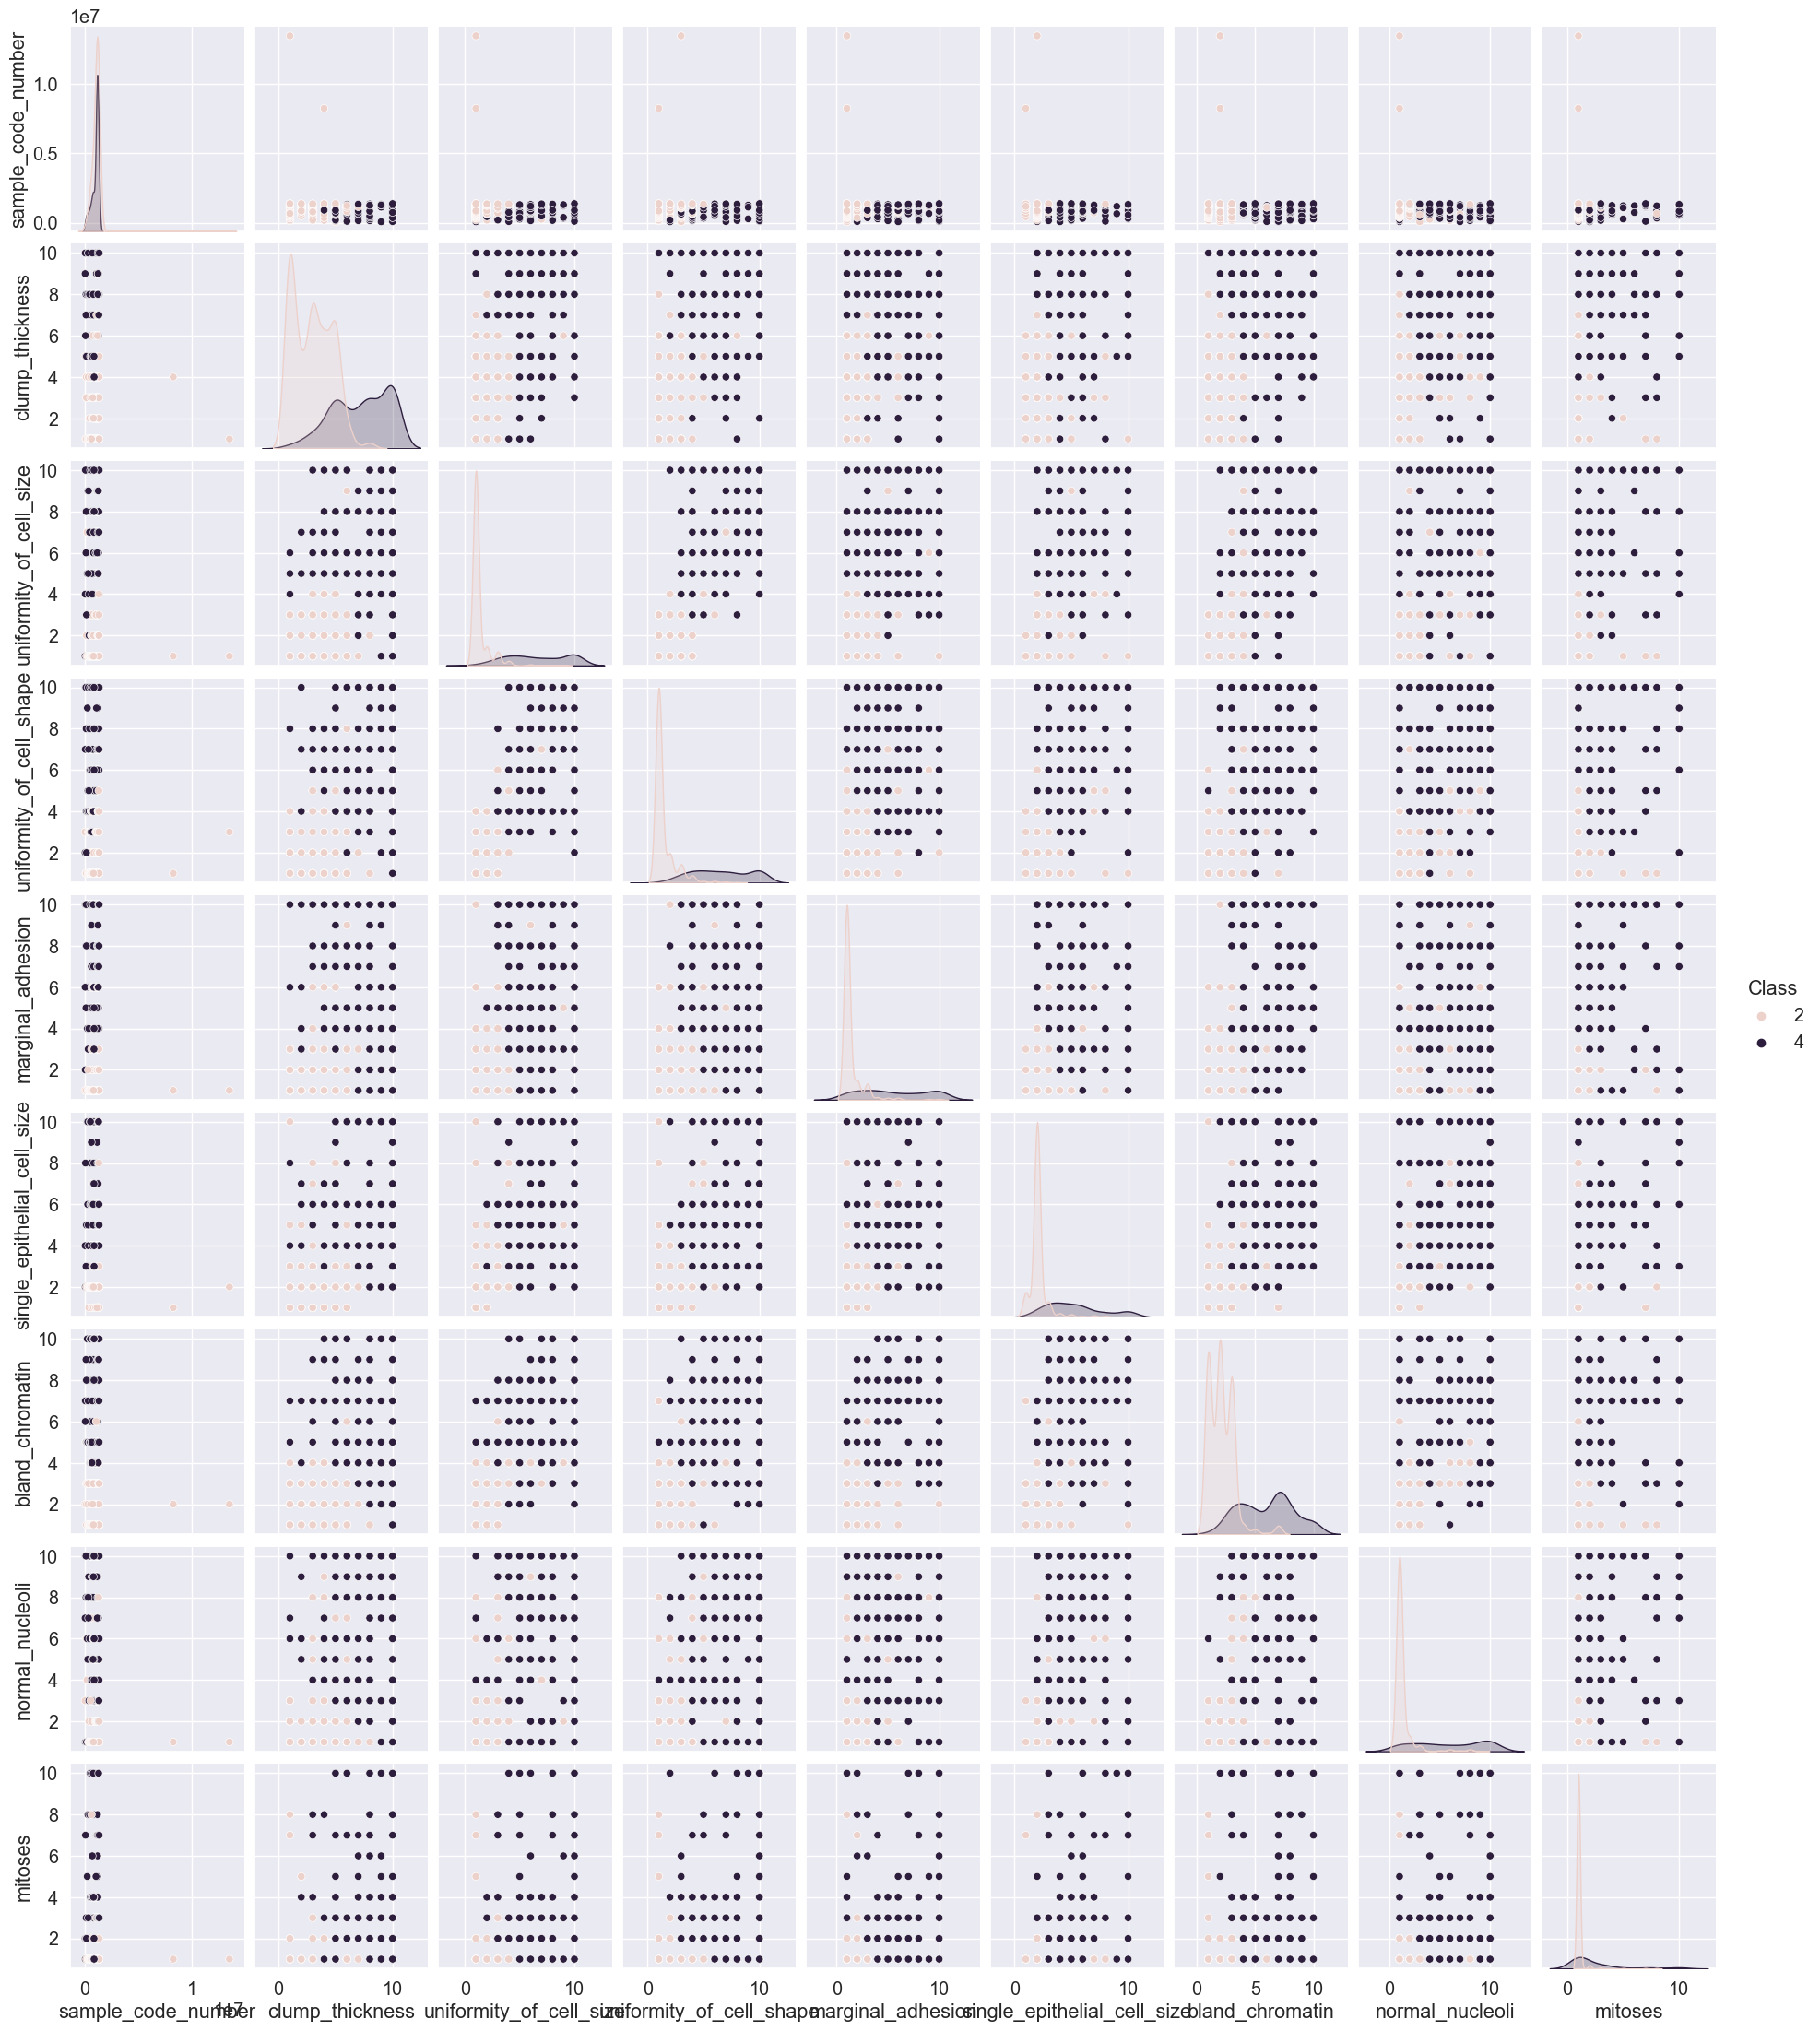

In [4]:
sns.set_style('darkgrid')
sns.set(font_scale=1.3)
sns.pairplot(
    data=ds, 
    aspect=.85,
    hue='Class');

Clear differentiation between Class 2 (Benevolent) and Class 4 (Malignant)

2. We study correlation

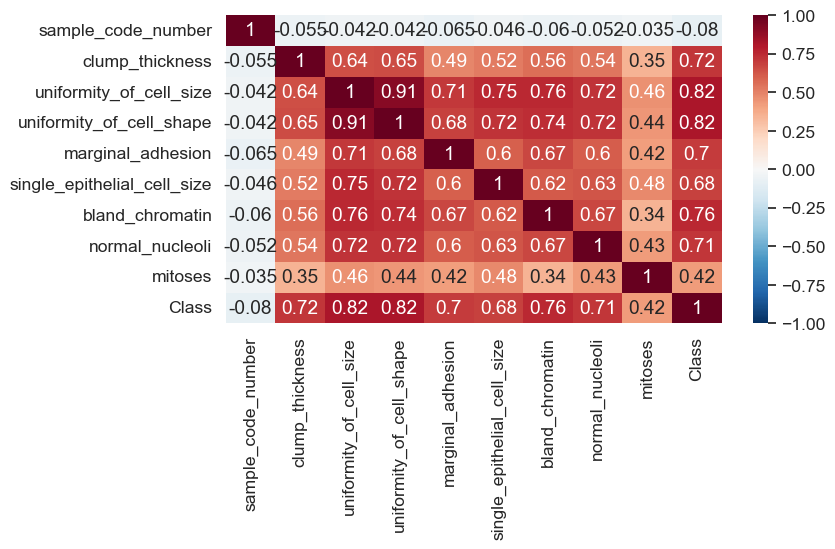

In [5]:
sns.set(font_scale=1.15)
plt.figure(figsize=(8,4))
sns.heatmap(
    ds.corr(),        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1);

Very clear data relationships

## 3: Data treatment

### Check data

#### Check for null values

In [6]:
ds.isnull().values.any()

False

#### Check for missing data

In [7]:
ds.isin(['?']).any()

sample_code_number             False
clump_thickness                False
uniformity_of_cell_size        False
uniformity_of_cell_shape       False
marginal_adhesion              False
single_epithelial_cell_size    False
bare_nuclei                     True
bland_chromatin                False
normal_nucleoli                False
mitoses                        False
Class                          False
dtype: bool

Some missing data in 'bare_nuclei' column

#### Check for types

In [8]:
print(ds.dtypes) 

sample_code_number              int64
clump_thickness                 int64
uniformity_of_cell_size         int64
uniformity_of_cell_shape        int64
marginal_adhesion               int64
single_epithelial_cell_size     int64
bare_nuclei                    object
bland_chromatin                 int64
normal_nucleoli                 int64
mitoses                         int64
Class                           int64
dtype: object


Some problem with types in 'bare_nuclei'

### Fill missing data

In [9]:
ds['bare_nuclei'] = pd.to_numeric(ds['bare_nuclei'], errors='coerce').fillna(0) # we change values to mean
ds['bare_nuclei'] = ds['bare_nuclei'].astype(np.int64) # convert column to int

We check it worked

In [10]:
ds.isin(['?']).any()

sample_code_number             False
clump_thickness                False
uniformity_of_cell_size        False
uniformity_of_cell_shape       False
marginal_adhesion              False
single_epithelial_cell_size    False
bare_nuclei                    False
bland_chromatin                False
normal_nucleoli                False
mitoses                        False
Class                          False
dtype: bool

In [11]:
print(ds.dtypes) 

sample_code_number             int64
clump_thickness                int64
uniformity_of_cell_size        int64
uniformity_of_cell_shape       int64
marginal_adhesion              int64
single_epithelial_cell_size    int64
bare_nuclei                    int64
bland_chromatin                int64
normal_nucleoli                int64
mitoses                        int64
Class                          int64
dtype: object


### Treat classes
Right now, classes are 2 and 4. We need to convert them to 0 and 1

In [15]:
ds['Class'] = ds['Class'].replace({2:0, 4:1})
print(ds['Class'][:10].to_string())

0    0
1    0
2    0
3    0
4    0
5    1
6    0
7    0
8    0
9    0


### Test / Train data split

In [16]:
#Seperating IV and DV
X = ds.iloc[:,1:10] # grab columns containing data (we ignore the codes now)
y = ds['Class'] # grab column with labels
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=42) #split

## 4: Model creation

### Constructing functions

#### Sigmoid function

In [17]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
    g = 1/(1+np.exp(-z))    
    return g

#### Regularized cost function

In [18]:
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X : (array_like Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : (array_like Shape (n,)) Values of bias parameter of the model
      lambda_ : (scalar, float)    Controls amount of regularization
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape
    
    total_cost = 0.
    for i in range(m):
        total_cost += -y[i]*np.log(sigmoid(np.dot(X[i], w)+b)) - (1-y[i])*np.log(1-sigmoid(np.dot(X[i], w)+b))
        
    total_cost /= m 
    
    reg_cost = 0.
    
    for i in range(n):
        reg_cost += w[i]**2
        
    
    # Add the regularization cost to get the total cost
    total_cost += (lambda_/(2 * m)) * reg_cost

    return total_cost

#### Regularized gradient function

In [19]:
def compute_gradient_reg(X, y, w, b, lambda_=1): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m):
        err = sigmoid(np.dot(X[i],w)+b) -y[i]
        for j in range(n):
            dj_dw[j] += err * X[i][j]
        dj_db += err
        
    dj_dw /= m
    dj_db /= m
    
    dj_dw += lambda_*w / m  # regularization
        
    return dj_db, dj_dw

#### Gradient descent function

In [20]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

Prediction function

In [21]:
def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)

    for i in range(m):   
        f_wb = sigmoid(np.dot(X[i], w) + b)
        if (f_wb >= 0.5): 
            p[i] = 1
        else:
            p[i] = 0
        
    return p

### Creating the model

In [22]:
# Fitting parameters
np.random.seed(1)
initial_w = np.zeros(X.shape[1])
initial_b = 0.

# Regularization parameter lambda_
lambda_ = 0.01

# Gradient descent settings
iterations = 10000
alpha = 0.1

w,b, J_history,_ = gradient_descent(X_train.to_numpy().astype(np.float32), y_train.to_numpy().astype(np.float32), initial_w, initial_b, 
                                    compute_cost_reg, compute_gradient_reg, 
                                    alpha, iterations, lambda_)

Iteration    0: Cost     0.74   
Iteration 1000: Cost     0.12   
Iteration 2000: Cost     0.10   
Iteration 3000: Cost     0.09   
Iteration 4000: Cost     0.09   
Iteration 5000: Cost     0.08   
Iteration 6000: Cost     0.08   
Iteration 7000: Cost     0.08   
Iteration 8000: Cost     0.08   
Iteration 9000: Cost     0.08   
Iteration 9999: Cost     0.08   


## 5: Model evaluation

### Checking cost over time

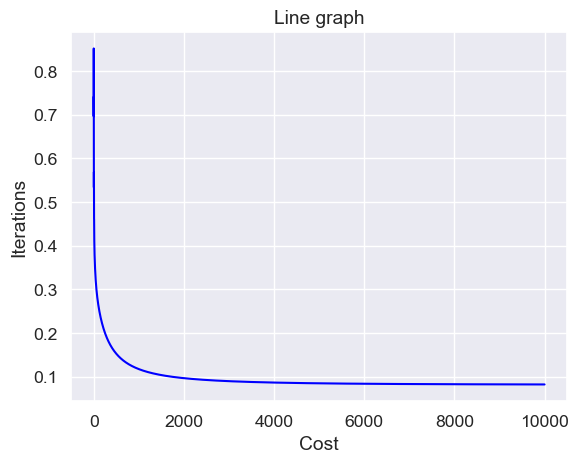

In [23]:
# plotting
plt.title("Line graph")
plt.xlabel("Cost")
plt.ylabel("Iterations")
plt.plot(J_history, color ="blue")
plt.show()

### Checking learned parameters

In [24]:
print(f"w = {w}")
print(f"b = {b}")

w = [0.4774223  0.03663049 0.40609228 0.18916689 0.08032621 0.42193578
 0.34508782 0.0112522  0.30646927]
b = -8.780370515087691


### Confusion Matrix

<AxesSubplot:>

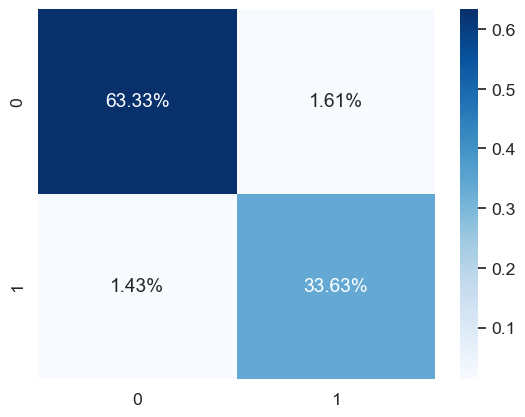

In [25]:
#Generate predictions with the model using our X values
p_train = predict(X_train.to_numpy(), w, b)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_train, p_train)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')


### Calculating accuracy

In [26]:
p_train = predict(X_train.to_numpy(), w, b)
print('Train Accuracy: %f'%(np.mean(p_train == y_train) * 100))

Train Accuracy: 96.958855


In [27]:
p_test = predict(X_test.to_numpy(), w, b)
print('Train Accuracy: %f'%(np.mean(p_test == y_test) * 100))

Train Accuracy: 96.428571


Pretty good! :)